In [2]:
# Libreria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import unicodedata

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score
)
from scipy.stats import randint  # para RandomizedSearch

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42



Subir archivo (Colab) y cargar DataFrame de forma robusta
---

In [3]:

# Carga de datos (CSV oficial MAGyP)
# Fuente pública (Ministerio de Agricultura): serie por campaña, provincia, departamento
# con cultivo y variables productivas (superficie, producción, rendimiento).

try:
    from google.colab import files
    uploaded = files.upload()
except Exception as e:
    print("Nota: si no estás en Colab, ignorá esta celda.", e)



Saving estimaciones-agricolas-2023-10.csv to estimaciones-agricolas-2023-10.csv


In [4]:
#Carga robusta del CSV local
import pandas as pd
from pathlib import Path

csv_local = Path("estimaciones-agricolas-2023-10.csv")

def cargar_csv_robusto(path: Path):
    """
    Intenta leer el CSV probando:
    - separador ',' y ';'
    - decimales '.' y ','
    - encoding utf-8 y latin-1
    Devuelve df (DataFrame) o levanta la última excepción.
    """
    intentos = [
        dict(sep=",", decimal=".", encoding="utf-8"),
        dict(sep=",", decimal=",", encoding="utf-8"),
        dict(sep=";", decimal=",", encoding="utf-8"),
        dict(sep=";", decimal=".", encoding="utf-8"),
        dict(sep=",", decimal=".", encoding="latin-1"),
        dict(sep=",", decimal=",", encoding="latin-1"),
        dict(sep=";", decimal=",", encoding="latin-1"),
        dict(sep=";", decimal=".", encoding="latin-1"),
    ]
    last_err = None
    for opt in intentos:
        try:
            df_try = pd.read_csv(path, low_memory=False, **opt)

            if df_try.shape[1] <= 1:
                raise ValueError(f"Probable separador errado con opciones: {opt}")
            return df_try
        except Exception as e:
            last_err = e
    raise last_err

if not csv_local.exists():
    raise FileNotFoundError(
        f"No encuentro {csv_local}. Verificá el nombre o volvé a subir el archivo."
    )

df = cargar_csv_robusto(csv_local)
print("Carga OK — shape:", df.shape)
print("Primeras columnas:", list(df.columns)[:12])
df.head(3)


Carga OK — shape: (153889, 12)
Primeras columnas: ['provincia_id', 'provincia_nombre', 'departamento_id', 'departamento_nombre', 'id_cultivo', 'cultivo', 'id_ciclo', 'ciclo', 'sup_sembrada', 'sup_cosechada', 'produccion', 'rendimiento']


,provincia_id,provincia_nombre,departamento_id,departamento_nombre,id_cultivo,cultivo,id_ciclo,ciclo,sup_sembrada,sup_cosechada,produccion,rendimiento
0,6,Buenos Aires,854,25 de Mayo,1.0,Ajo,1,1969/1970,3,3,10,3333
1,6,Buenos Aires,14,Adolfo Gonzales Chaves,1.0,Ajo,1,1969/1970,15,15,82,5467
2,6,Buenos Aires,21,Alberti,1.0,Ajo,1,1969/1970,5,5,7,1400


Normalizar nombres de columnas y chequear las claves que uso
---

In [5]:
# Estandarizamos nombres
df = df.rename(columns={
    "ciclo": "campana",
    "provincia_nombre": "provincia",
    "departamento_nombre": "departamento",
    "sup_sembrada": "superficie_sembrada_ha",
    "sup_cosechada": "superficie_cosechada_ha",
    "produccion": "produccion_tn",
    "rendimiento": "rendimiento_kg_ha"
})

# Normalizamos valores de 'cultivo' a Título (por si vienen en mayúsculas/minúsculas)
if df["cultivo"].dtype == object:
    df["cultivo"] = df["cultivo"].str.strip().str.title()

print(sorted(df.columns))
df[["campana","provincia","departamento","cultivo"]].head(3)



['campana', 'cultivo', 'departamento', 'departamento_id', 'id_ciclo', 'id_cultivo', 'produccion_tn', 'provincia', 'provincia_id', 'rendimiento_kg_ha', 'superficie_cosechada_ha', 'superficie_sembrada_ha']


,campana,provincia,departamento,cultivo
0,1969/1970,Buenos Aires,25 de Mayo,Ajo
1,1969/1970,Buenos Aires,Adolfo Gonzales Chaves,Ajo
2,1969/1970,Buenos Aires,Alberti,Ajo


Selección de variables, limpieza y ajuste de etiquetas
---

In [6]:
# Definición de columnas a usar
cat_cols = ["campana", "provincia", "departamento"]
num_cols = ["superficie_sembrada_ha","superficie_cosechada_ha","produccion_tn","rendimiento_kg_ha"]
target_col = "cultivo"

# Asegurar que existan
for c in cat_cols + num_cols + [target_col]:
    if c not in df.columns:
        raise KeyError(f"Falta la columna requerida: {c}")

# Tipos numéricos
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Ajuste de etiquetas (p.ej. "Maiz" -> "Maíz")
df[target_col] = df[target_col].replace({"Maiz":"Maíz"})

# Filtrar a 5 cultivos principales
top_cultivos = ["Trigo", "Maíz", "Soja", "Girasol", "Cebada"]
df = df[df[target_col].isin(top_cultivos)].dropna(subset=cat_cols + num_cols).copy()

print("Tamaño post-filtrado:", df.shape)
print("\nDistribución de clases:")
print(df[target_col].value_counts())
df.head(3)


Tamaño post-filtrado: (27347, 12)

Distribución de clases:
cultivo
Maíz       17113
Girasol    10234
Name: count, dtype: int64


,provincia_id,provincia,departamento_id,departamento,id_cultivo,cultivo,id_ciclo,campana,superficie_sembrada_ha,superficie_cosechada_ha,produccion_tn,rendimiento_kg_ha
1778,6,Buenos Aires,854,25 de Mayo,14.0,Girasol,1,1969/1970,30000,30000.0,22500.0,750.0
1779,6,Buenos Aires,588,9 de Julio,14.0,Girasol,1,1969/1970,50000,50000.0,41316.0,826.0
1780,6,Buenos Aires,7,Adolfo Alsina,14.0,Girasol,1,1969/1970,10000,10000.0,9000.0,900.0


In [7]:
# Activo submuestreo porque el dataset es muy grande
USE_SUBSAMPLE = True
N_PER_CLASS = 800
if USE_SUBSAMPLE:
    df_fast = (df.groupby(target_col, group_keys=False)
                 .apply(lambda g: g.sample(min(len(g), N_PER_CLASS), random_state=RANDOM_STATE))
                 .reset_index(drop=True))
else:
    df_fast = df.copy()

print("Dataset usado para modelado:", df_fast.shape)
print(df_fast[target_col].value_counts())


Dataset usado para modelado: (1600, 12)
cultivo
Girasol    800
Maíz       800
Name: count, dtype: int64


/tmp/ipython-input-3196489293.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), N_PER_CLASS), random_state=RANDOM_STATE))


One-hot y split 80/20
---

In [8]:
# One-Hot de categóricas + mantener numéricas
X = pd.get_dummies(df_fast[cat_cols + num_cols], drop_first=False)
y = df_fast[target_col].copy()

print("Shape X, y:", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Shape X, y: (1600, 398) (1600,)
Train: (1280, 398) | Test: (320, 398)


K-NN (Pipeline + GridSearchCV con F1-macro)
---

In [9]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# ↓↓↓ reducir memoria: pasamos a float32
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")

pipe_knn = Pipeline([
    # MaxAbsScaler no centra y es súper liviano (ideal para dummies)
    ("scaler", MaxAbsScaler()),
    ("knn", KNeighborsClassifier())
])

# Grid chico y CV=3 (rápido y estable)
param_knn = {
    "knn__n_neighbors": [5, 9],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

# n_jobs=1 para evitar que el paralelismo reviente la RAM
knn_search = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_knn,
    cv=3,
    n_jobs=1,              # ← clave para evitar SIGKILL por memoria
    scoring="f1_macro",
    verbose=0
)

knn_search.fit(X_train, y_train)
print("Mejores params KNN:", knn_search.best_params_)




Mejores params KNN: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


Árbol de Decisión (GridSearchCV con F1-macro)
---

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_tree = {
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [3, 10],
    "max_features": [None, "sqrt"],
    "criterion": ["gini","entropy"]
}
tree_search = GridSearchCV(tree, param_tree, cv=3, n_jobs=-1, scoring="f1_macro")
tree_search.fit(X_train, y_train)
print("Mejores params Árbol:", tree_search.best_params_)


Mejores params Árbol: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 3}


Evaluación (Accuracy + F1-macro/weighted + CM) y guardado de figuras
---


=== K-NN ===
Mejores parámetros: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Accuracy (train): 0.8336 | F1-macro (train): 0.8319
Accuracy (test):  0.8000 | F1-macro (test):  0.7968 | F1-weighted (test): 0.7968

Reporte de clasificación (test):
              precision    recall  f1-score   support

     Girasol     0.7400    0.9250    0.8222       160
        Maíz     0.9000    0.6750    0.7714       160

    accuracy                         0.8000       320
   macro avg     0.8200    0.8000    0.7968       320
weighted avg     0.8200    0.8000    0.7968       320



<Figure size 750x750 with 0 Axes>

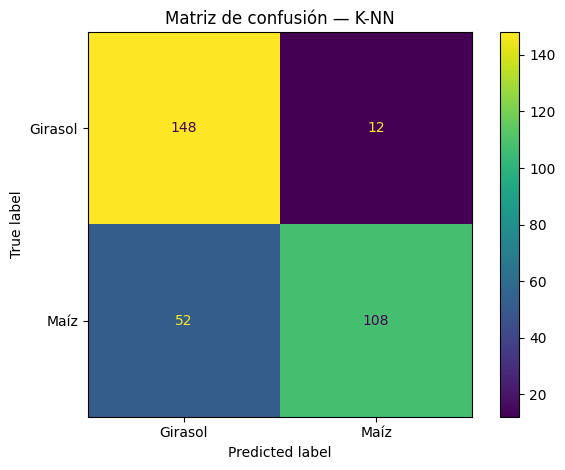

Guardado: figs/cm_k-nn.png

=== Árbol de Decisión ===
Mejores parámetros: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 3}
Accuracy (train): 0.9383 | F1-macro (train): 0.9382
Accuracy (test):  0.8656 | F1-macro (test):  0.8652 | F1-weighted (test): 0.8652

Reporte de clasificación (test):
              precision    recall  f1-score   support

     Girasol     0.8305    0.9187    0.8724       160
        Maíz     0.9091    0.8125    0.8581       160

    accuracy                         0.8656       320
   macro avg     0.8698    0.8656    0.8652       320
weighted avg     0.8698    0.8656    0.8652       320



<Figure size 750x750 with 0 Axes>

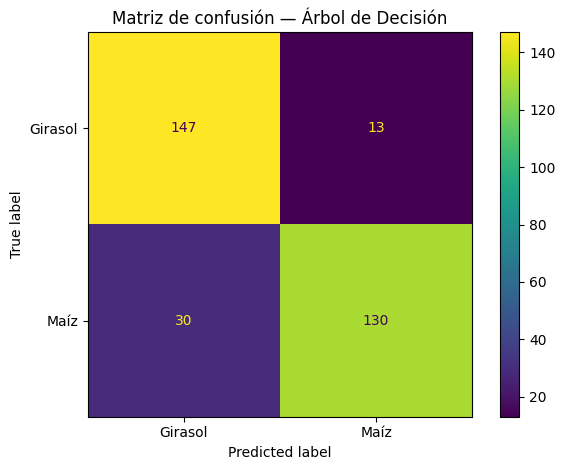

Guardado: figs/cm_árbol_de_decisión.png


In [11]:
import os
os.makedirs("figs", exist_ok=True)

def evaluar(nombre, model):
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)

    acc_tr = accuracy_score(y_train, yhat_tr)
    acc_te = accuracy_score(y_test,  yhat_te)
    f1m_tr = f1_score(y_train, yhat_tr, average="macro")
    f1m_te = f1_score(y_test,  yhat_te, average="macro")
    f1w_te = f1_score(y_test,  yhat_te, average="weighted")

    print(f"\n=== {nombre} ===")
    print("Mejores parámetros:", getattr(model, "best_params_", "N/A"))
    print(f"Accuracy (train): {acc_tr:.4f} | F1-macro (train): {f1m_tr:.4f}")
    print(f"Accuracy (test):  {acc_te:.4f} | F1-macro (test):  {f1m_te:.4f} | F1-weighted (test): {f1w_te:.4f}")
    print("\nReporte de clasificación (test):")
    print(classification_report(y_test, yhat_te, digits=4))

    plt.figure(figsize=(5,5), dpi=150)
    ConfusionMatrixDisplay.from_predictions(y_test, yhat_te)
    plt.title(f"Matriz de confusión — {nombre}")
    plt.grid(False)
    plt.tight_layout()
    fname = f"figs/cm_{nombre.replace(' ','_').lower()}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print("Guardado:", fname)

evaluar("K-NN", knn_search)
evaluar("Árbol de Decisión", tree_search)



Comparativa final (ordenada por F1-macro) + CSV
---

In [12]:
resumen = pd.DataFrame({
    "Modelo": ["K-NN", "Árbol de Decisión"],
    "F1_macro_test": [
        f1_score(y_test, knn_search.predict(X_test), average="macro"),
        f1_score(y_test, tree_search.predict(X_test), average="macro")
    ],
    "F1_weighted_test": [
        f1_score(y_test, knn_search.predict(X_test), average="weighted"),
        f1_score(y_test, tree_search.predict(X_test), average="weighted")
    ],
    "Accuracy_test": [
        accuracy_score(y_test, knn_search.predict(X_test)),
        accuracy_score(y_test, tree_search.predict(X_test))
    ]
}).sort_values("F1_macro_test", ascending=False)

print("\nComparativa (ordenada por F1-macro en test):")
print(resumen.to_string(index=False))

resumen.to_csv("resultados_clase5_granos.csv", index=False)
print("Guardado: resultados_clase5_granos.csv")



Comparativa (ordenada por F1-macro en test):
           Modelo  F1_macro_test  F1_weighted_test  Accuracy_test
Árbol de Decisión       0.865245          0.865245       0.865625
             K-NN       0.796825          0.796825       0.800000
Guardado: resultados_clase5_granos.csv


Árbol de Decisión
---

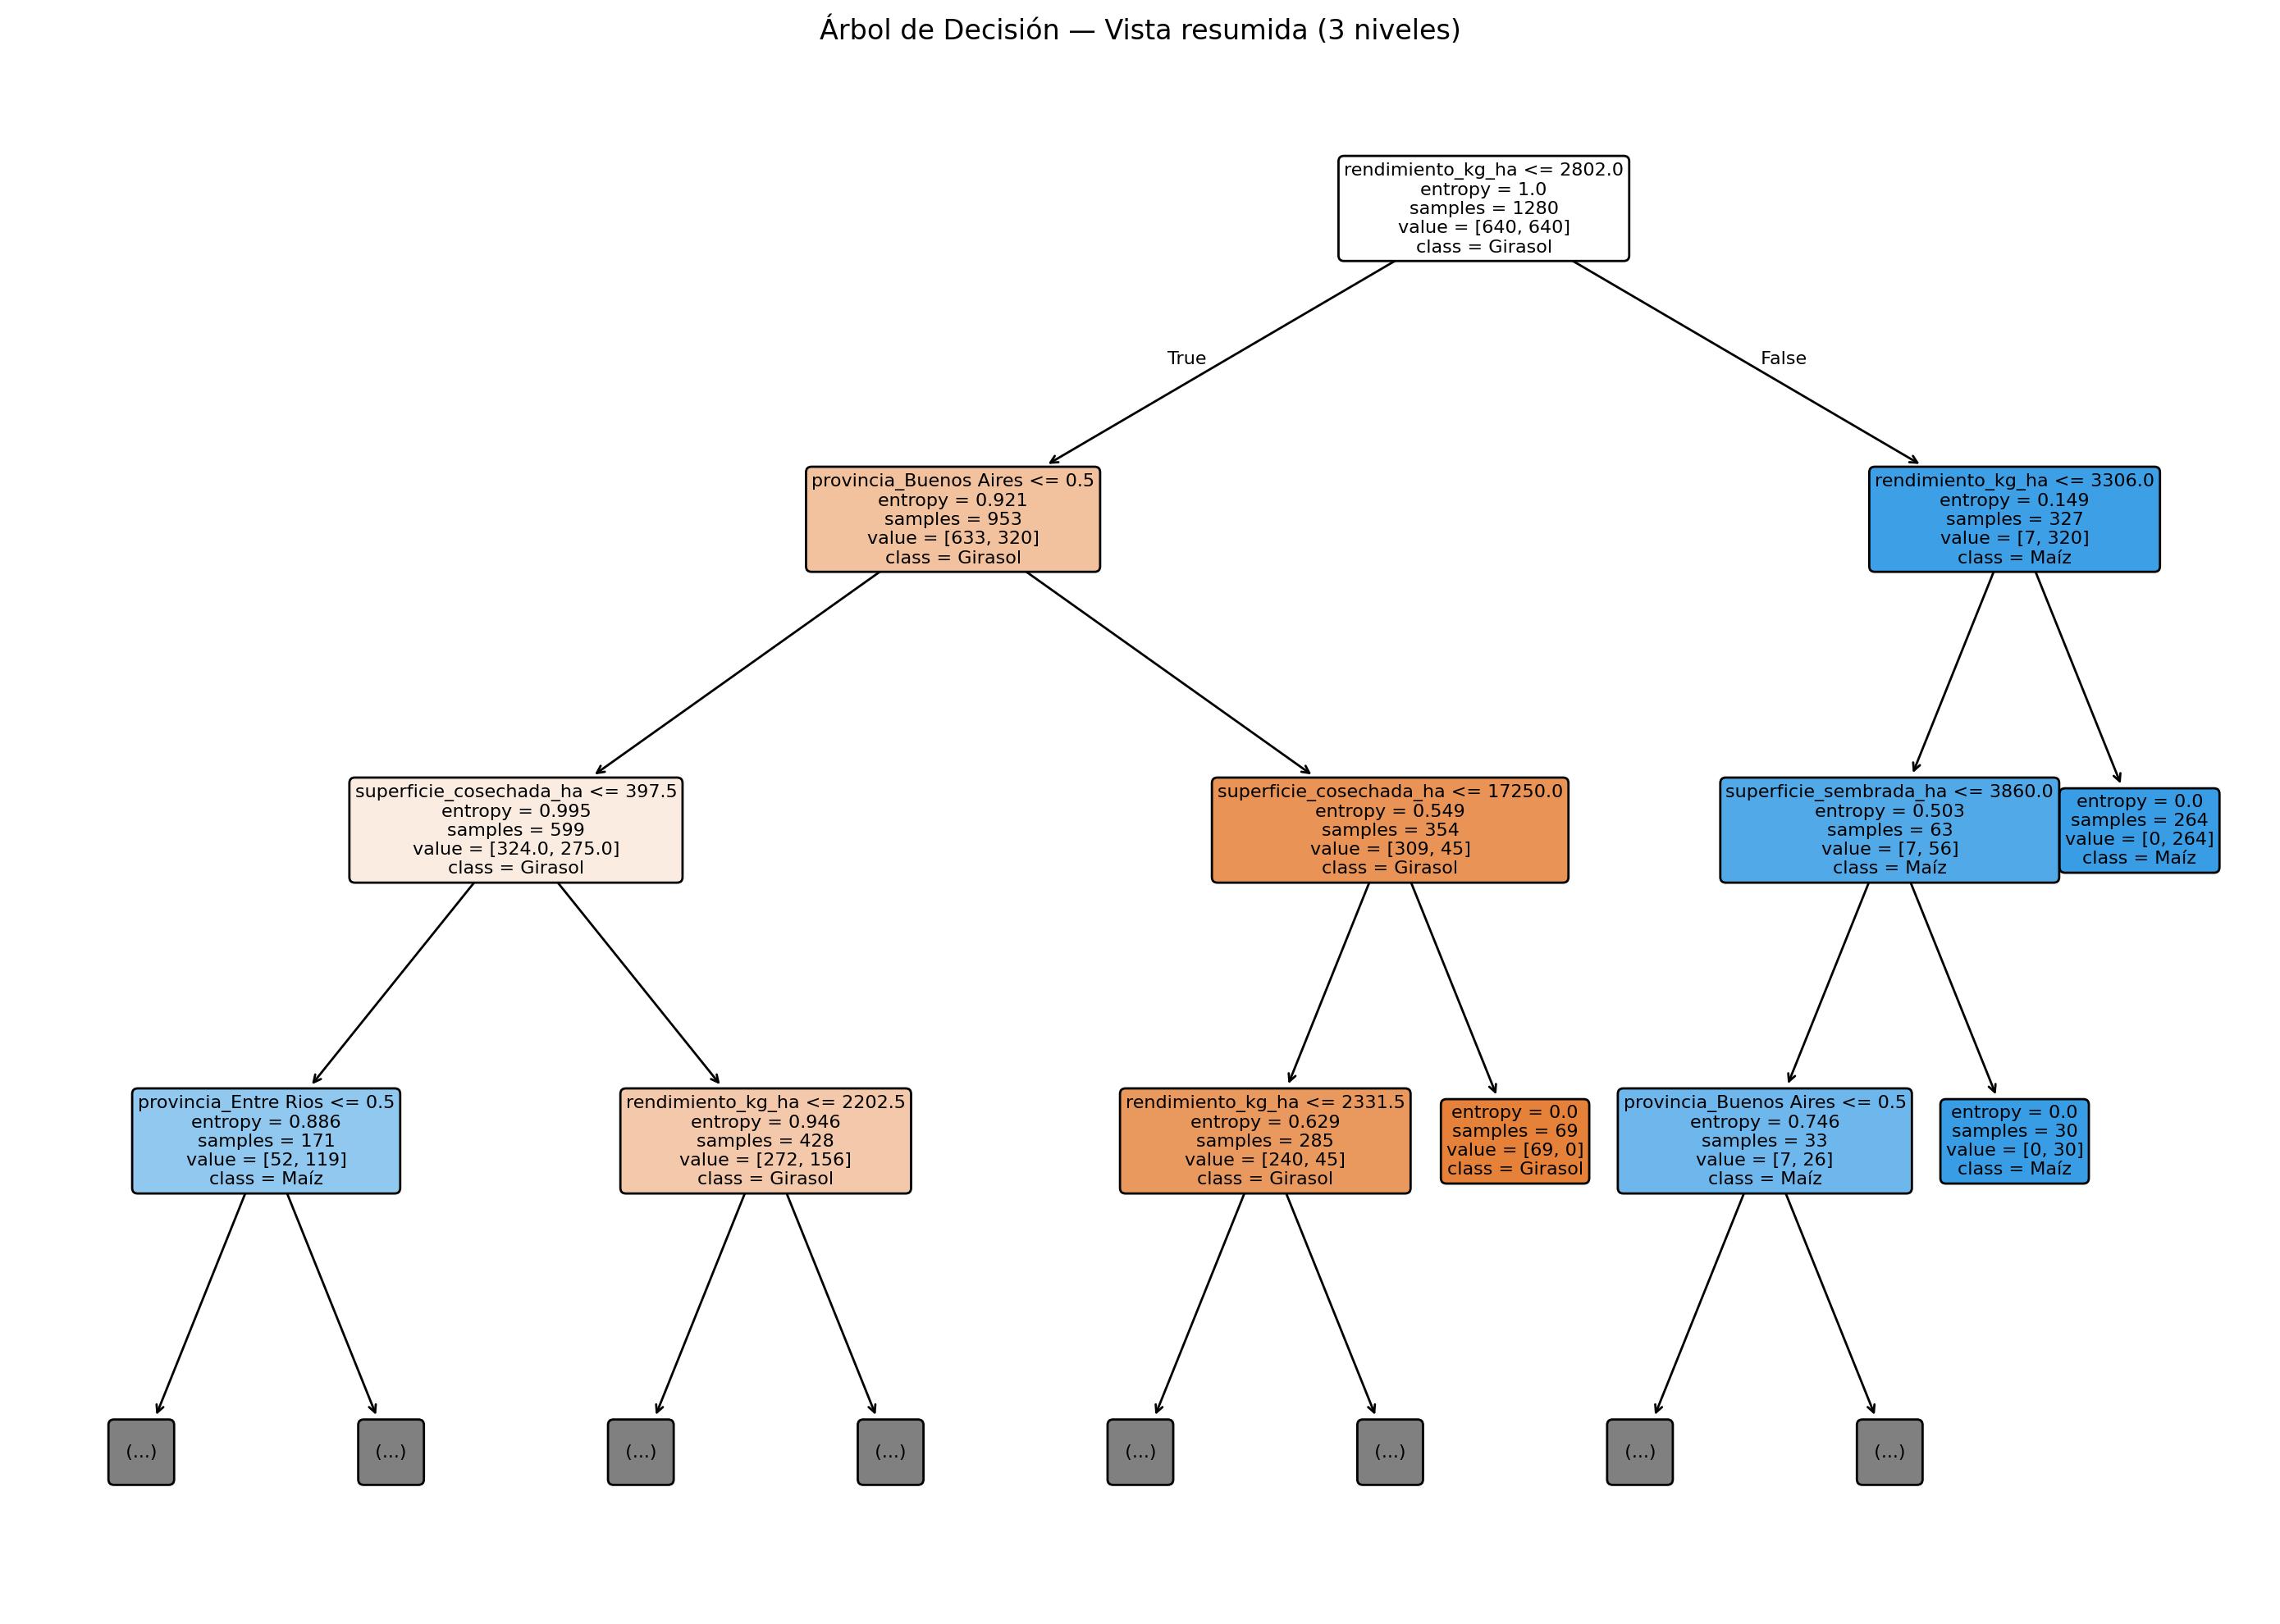

Guardado: figs/arbol_resumido_n3.png
Guardado: figs/arbol_completo.pdf


In [13]:
from sklearn import tree as _tree

mejor_arbol = tree_search.best_estimator_
feature_names = list(X.columns)
class_names   = sorted(y_train.unique().tolist())

# Resumen (3 niveles) — ideal para el cuerpo del informe
plt.figure(figsize=(14, 10), dpi=200)
_tree.plot_tree(
    mejor_arbol,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8
)
plt.title("Árbol de Decisión — Vista resumida (3 niveles)")
plt.tight_layout()
plt.savefig("figs/arbol_resumido_n3.png", dpi=200)
plt.show()
print("Guardado: figs/arbol_resumido_n3.png")

# Completo en PDF (anexo)
plt.figure(figsize=(28, 24), dpi=300)
_tree.plot_tree(
    mejor_arbol,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=6
)
plt.title("Árbol de Decisión — Completo")
plt.tight_layout()
plt.savefig("figs/arbol_completo.pdf")
plt.close()
print("Guardado: figs/arbol_completo.pdf")



K-NN: Curva de k (F1-macro) para justificar el k elegido
---

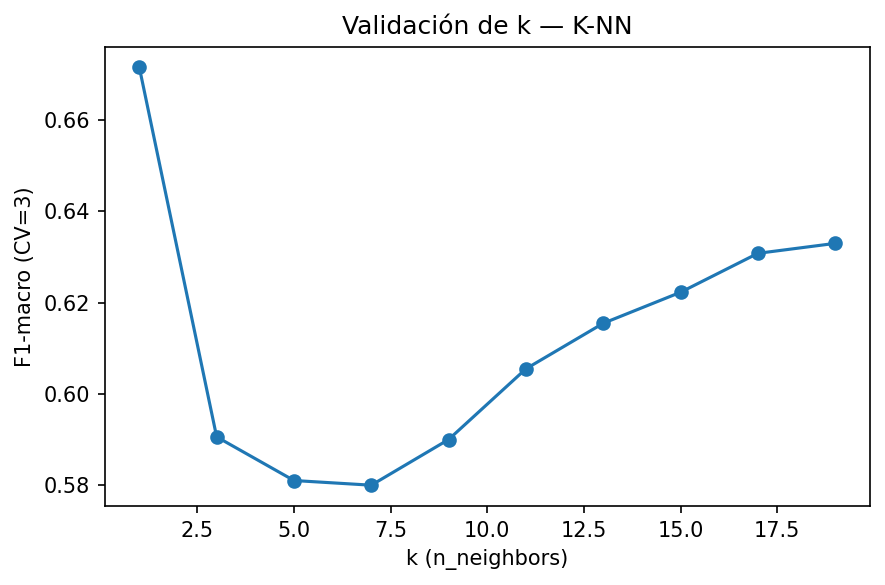

Guardado: figs/knn_curva_k_f1macro.png


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

ks = [1,3,5,7,9,11,13,15,17,19]
scores = []

for k in ks:
    pipe = Pipeline([
        # Usá el mismo escalado liviano que en la Celda 6 si preferís:
        # ("scaler", MaxAbsScaler()),
        ("scaler", StandardScaler(with_mean=False)),
        ("knn", KNeighborsClassifier(
            n_neighbors=k,
            p=knn_search.best_params_.get("knn__p", 2),
            weights=knn_search.best_params_.get("knn__weights", "uniform")
        ))
    ])
    # Para evitar problemas de RAM en Colab: n_jobs=1
    cv = cross_val_score(pipe, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=1)
    scores.append(cv.mean())

plt.figure(figsize=(6,4), dpi=150)
plt.plot(ks, scores, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("F1-macro (CV=3)")
plt.title("Validación de k — K-NN")
plt.tight_layout()
plt.savefig("figs/knn_curva_k_f1macro.png", dpi=150)
plt.show()

print("Guardado: figs/knn_curva_k_f1macro.png")



K-NN: Fronteras 2D con PCA
---

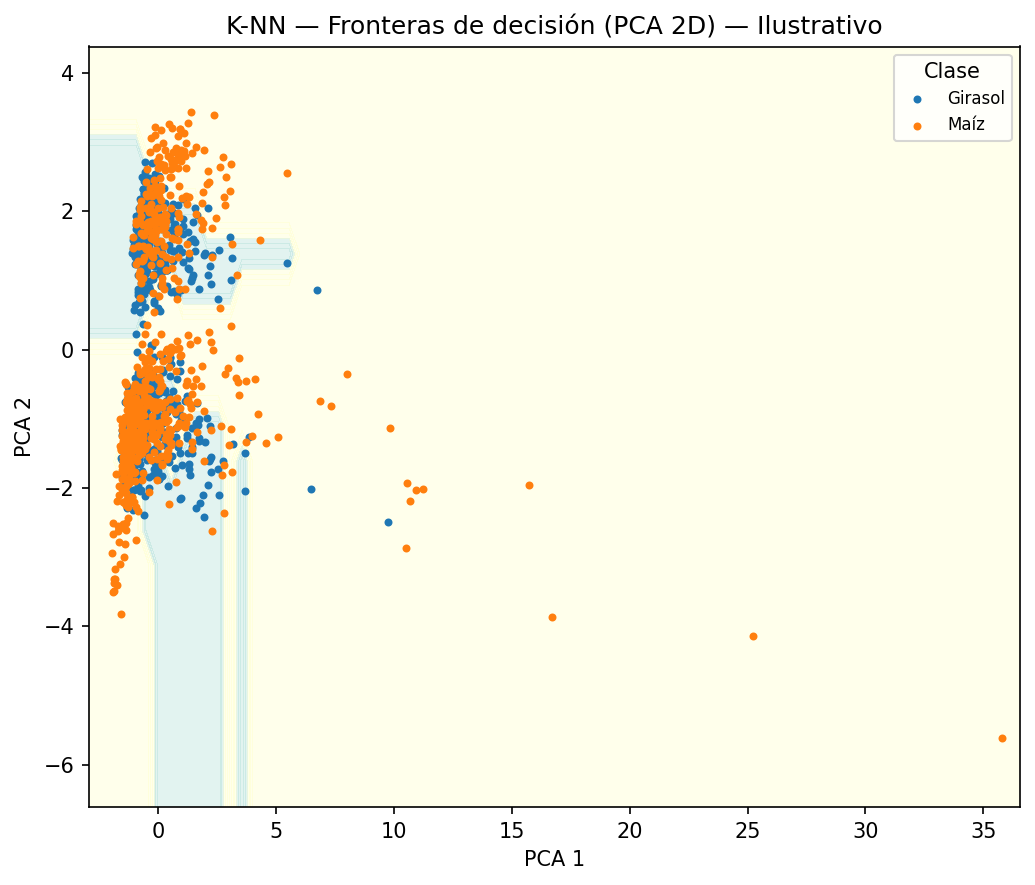

Guardado: figs/knn_fronteras_pca2d.png


In [18]:
#Fronteras 2D (PCA)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

# Escalar + PCA (2 componentes) sobre TRAIN
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d  = pca.transform(X_test_scaled)

# Mapear clases a enteros
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
classes = le.classes_.tolist()

# Entrenar un KNN en el plano 2D con los MEJORES parámetros del pipeline principal
knn2d = KNeighborsClassifier(
    n_neighbors = knn_search.best_params_.get("knn__n_neighbors", 5),
    p           = knn_search.best_params_.get("knn__p", 2),
    weights     = knn_search.best_params_.get("knn__weights", "uniform")
)
knn2d.fit(X_train_2d, y_train_int)

# Grilla para el mapa de decisión
h = 0.5
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h, dtype=float),
                     np.arange(y_min, y_max, h, dtype=float))

# Predicción sobre la grilla y reshape a enteros
Z = knn2d.predict(np.c_[xx.ravel(), yy.ravel()]).astype(int)
Z = Z.reshape(xx.shape)

# Colores de fondo por clase + puntos del TRAIN
plt.figure(figsize=(7,6), dpi=150)
cmap_bg = ListedColormap(plt.cm.Set3.colors[:len(classes)])
plt.contourf(xx, yy, Z, alpha=0.25, cmap=cmap_bg)

for cls_idx, cls_name in enumerate(classes):
    mask = (y_train_int == cls_idx)
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], s=8, label=cls_name)

plt.legend(title="Clase", fontsize=8)
plt.title("K-NN — Fronteras de decisión (PCA 2D) — Ilustrativo")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.savefig("figs/knn_fronteras_pca2d.png", dpi=150)
plt.show()

print("Guardado: figs/knn_fronteras_pca2d.png")


Guardar métricas y matrices
---



OK -> resultados_clase5_granos.csv
OK -> figs/cm_k-nn.png
OK -> figs/cm_arbol_decision.png
OK -> figs/arbol_resumido_n3.png
OK -> figs/arbol_completo.pdf
OK -> figs/knn_curva_k_f1macro.png
OK -> figs/knn_fronteras_pca2d.png

Listo. Revisá la carpeta 'figs/' para insertar al PDF.


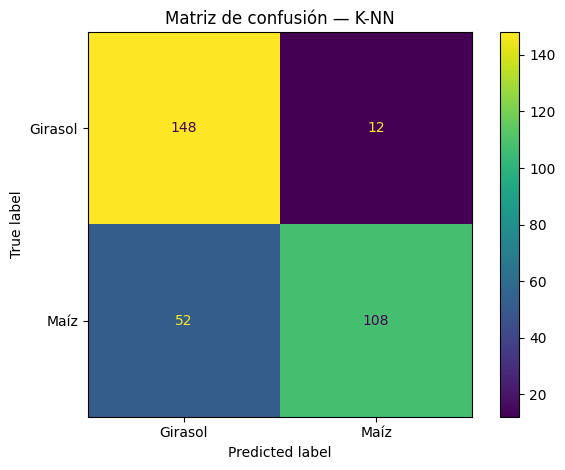

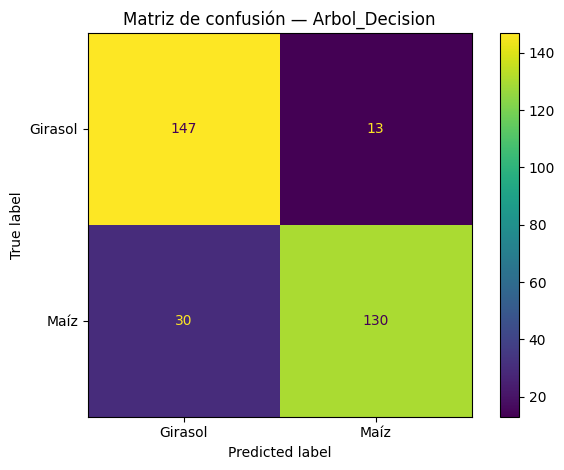

In [20]:

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree as _tree
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

# Carpeta
Path("figs").mkdir(parents=True, exist_ok=True)

# Guardar tabla de resultados (si la tenés en 'resumen')
try:
    resumen.to_csv("resultados_clase5_granos.csv", index=False)
    print("OK -> resultados_clase5_granos.csv")
except NameError:
    print("Aviso: no encontré 'resumen'. (Primero ejecutá la celda de la comparativa.)")

# Matrices de confusión (KNN + Árbol)
def guardar_cm(model, nombre):
    fig = plt.figure(figsize=(5,5), dpi=150)
    ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test))
    plt.title(f"Matriz de confusión — {nombre}")
    plt.grid(False)
    plt.tight_layout()
    out = f"figs/cm_{nombre.replace(' ','_').lower()}.png"
    fig.savefig(out, dpi=150)
    plt.close(fig)
    print("OK ->", out)

guardar_cm(knn_search, "K-NN")
guardar_cm(tree_search, "Arbol_Decision")

# Árbol de Decisión
try:
    mejor_arbol = tree_search.best_estimator_
    feature_names = list(X.columns)
    class_names   = sorted(y_train.unique().tolist())

    # Resumido (3 niveles)
    plt.figure(figsize=(14, 10), dpi=200)
    _tree.plot_tree(
        mejor_arbol,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True, max_depth=3, fontsize=8
    )
    plt.title("Árbol de Decisión — Vista resumida (3 niveles)")
    plt.tight_layout()
    plt.savefig("figs/arbol_resumido_n3.png", dpi=200)
    plt.close()
    print("OK -> figs/arbol_resumido_n3.png")


    plt.figure(figsize=(28, 24), dpi=300)
    _tree.plot_tree(
        mejor_arbol,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True, fontsize=6
    )
    plt.title("Árbol de Decisión — Completo")
    plt.tight_layout()
    plt.savefig("figs/arbol_completo.pdf")
    plt.close()
    print("OK -> figs/arbol_completo.pdf")
except Exception as e:
    print("Aviso Árbol:", e)

# Curva de k (F1-macro) para K-NN
try:
    ks = [3,5,7,9,11]
    scores = []
    for k in ks:
        pipe = Pipeline([
            ("scaler", MaxAbsScaler()),
            ("knn", KNeighborsClassifier(
                n_neighbors=k,
                p=knn_search.best_params_.get("knn__p", 2),
                weights=knn_search.best_params_.get("knn__weights","uniform")
            ))
        ])
        cv = cross_val_score(pipe, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=1)
        scores.append(cv.mean())

    plt.figure(figsize=(6,4), dpi=150)
    plt.plot(ks, scores, marker="o")
    plt.xlabel("k (n_neighbors)")
    plt.ylabel("F1-macro (CV=3)")
    plt.title("Validación de k — K-NN")
    plt.tight_layout()
    plt.savefig("figs/knn_curva_k_f1macro.png", dpi=150)
    plt.close()
    print("OK -> figs/knn_curva_k_f1macro.png")
except Exception as e:
    print("Aviso Curva k:", e)

# Fronteras de decisión (PCA 2D) — ilustrativo (robusto)
try:
    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    pca = PCA(n_components=2, random_state=42)
    X_train_2d = pca.fit_transform(X_train_scaled)

    le = LabelEncoder()
    y_train_int = le.fit_transform(y_train)
    classes = le.classes_.tolist()

    knn2d = KNeighborsClassifier(
        n_neighbors=knn_search.best_params_.get("knn__n_neighbors", 5),
        p=knn_search.best_params_.get("knn__p", 2),
        weights=knn_search.best_params_.get("knn__weights", "uniform")
    ).fit(X_train_2d, y_train_int)

    h = 0.7  # subir si falta memoria
    x_min, x_max = X_train_2d[:,0].min()-1, X_train_2d[:,0].max()+1
    y_min, y_max = X_train_2d[:,1].min()-1, X_train_2d[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h, dtype=float),
                         np.arange(y_min, y_max, h, dtype=float))
    Z = knn2d.predict(np.c_[xx.ravel(), yy.ravel()]).astype(int).reshape(xx.shape)

    plt.figure(figsize=(7,6), dpi=150)
    cmap_bg = ListedColormap(plt.cm.Set3.colors[:len(classes)])
    plt.contourf(xx, yy, Z, alpha=0.25, cmap=cmap_bg)
    for cls_idx, cls_name in enumerate(classes):
        mask = (y_train_int == cls_idx)
        plt.scatter(X_train_2d[mask,0], X_train_2d[mask,1], s=8, label=cls_name)
    plt.legend(title="Clase", fontsize=8)
    plt.title("K-NN — Fronteras de decisión (PCA 2D) — Ilustrativo")
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.tight_layout()
    plt.savefig("figs/knn_fronteras_pca2d.png", dpi=150)
    plt.close()
    print("OK -> figs/knn_fronteras_pca2d.png")
except Exception as e:
    print("Aviso Fronteras 2D:", e)

print("\nListo. Revisá la carpeta 'figs/' para insertar al PDF.")
